## 使用OpenCV 讀取YOLOv3模型

In [1]:
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("yolov3.cfg","yolov3_1100.weights")

In [2]:
layer_names = net.getLayerNames()
#print(layer_names)

In [3]:
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

## 讀取相關參數

In [4]:
classes = [line.strip() for line in open("cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]

## 讀取圖片

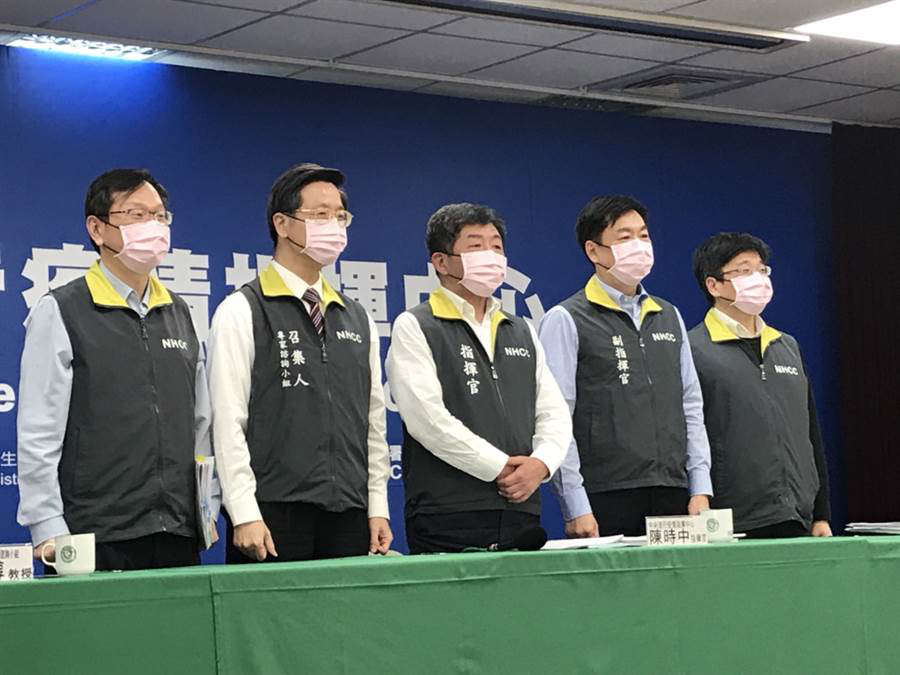

In [5]:
from PIL import Image
Image.open('/Users/davidchiu/Desktop/test.jpg')

In [6]:
img = cv2.imread("/Users/davidchiu/Desktop/test.jpg")
img.shape

(675, 900, 3)

## 利用YOLOv3 模型辨識圖片
- 320 x 320 (high speed, less accuracy)
- 416 x 416 (moderate speed, moderate accuracy)
- 608 x 608 (less speed, high accuracy)

In [7]:
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape 
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

In [8]:
len(outs)

3

In [9]:
outs[0].shape

(507, 8)

## 擷取偵測物件位置

In [10]:
%%html
<img src='https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png' width="500px" />

In [11]:
class_ids = []
confidences = []
boxes = []
    
for out in outs:
    for detection in out:
        tx, ty, tw, th, confidence = detection[0:5]
        scores = detection[5:]
        class_id = np.argmax(scores)  
        if confidence > 0.3:   
            center_x = int(tx * width)
            center_y = int(ty * height)
            w = int(tw * width)
            h = int(th * height)
            
            # 取得箱子方框座標
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [12]:
len(boxes)

9

## non-maxima suppression
- 去除多餘重疊且信心度低的箱型區域 


<img src='https://miro.medium.com/max/1400/1*OZwJcNsMZc7wT733fA_ITg.png' width="500px" />


In [ ]:
?cv2.dnn.NMSBoxes

In [13]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)

## 框住偵測物件區域

In [14]:
font = cv2.FONT_HERSHEY_PLAIN

for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 5), font, 2, color, 3)

In [15]:
img.shape

(270, 360, 3)

Populating the interactive namespace from numpy and matplotlib


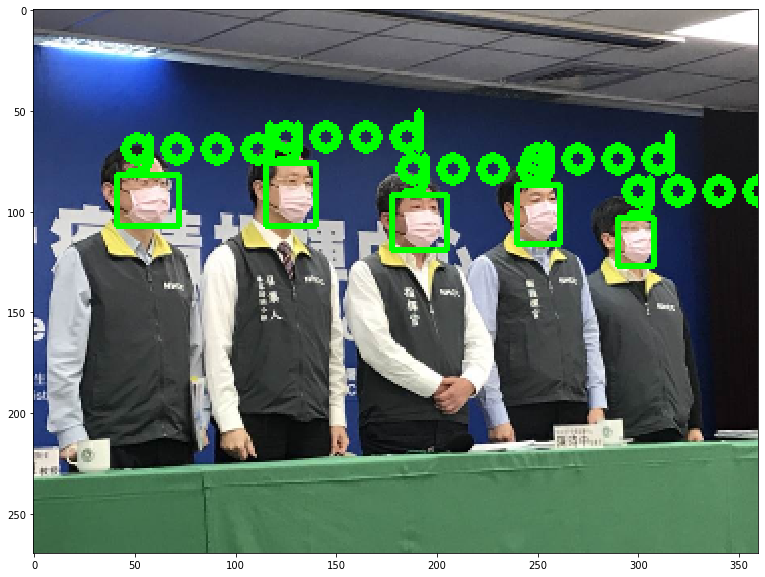

In [16]:
%pylab inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

## 將辨識過程包裝成函數

In [17]:
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("yolov3.cfg","yolov3_1100.weights")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
classes = [line.strip() for line in open("cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]

def yolo_detect(frame):
    # forward propogation
    img = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape 
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # get detection boxes
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.3:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                # 取得箱子方框座標
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y -5), font, 3, color, 3)
    return img

## 測試函數功能

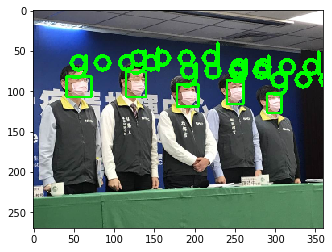

In [18]:
img = cv2.imread("/Users/davidchiu/Desktop/test.jpg")
im = yolo_detect(img)
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

## 使用攝像頭即時偵測物件

In [22]:
import cv2
import imutils
import time

VIDEO_IN = cv2.VideoCapture(0)

while True:
    hasFrame, frame = VIDEO_IN.read()
    
    img = yolo_detect(frame)
    cv2.imshow("Frame", imutils.resize(img, width=850))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()